# Imports

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from tqdm import tqdm

pd.set_option('display.max_columns', None)


tqdm.pandas()

In [2]:
# Got this idea from justin-hj-kim
# Use kmeans to create clusters that will represent districts, i'm going to use only lat/long data
# To train, i will use an 10% out-of-sample of training data, to avoid leak
df = pd.read_parquet('../data/train_test/full_valid.parquet.gzip')
print(df.shape)
df.head()

(174652, 25)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year_month_day,daily_preciptation_normal_inches,max_temperature_normal_f,min_temperature_normal_f,avg_temperature_normal_f,BIKE_LANE,BOROCODE,ST_WIDTH,TRAFDIR,RW_TYPE,SNOW_PRI,PRE_DIRECT,PRE_TYPE,POST_TYPE,BIKE_TRAFD,SEGMENT_TY
0,id1718206,1,2016-01-05 10:07:14,1,-73.990273,40.766647,-73.992729,40.748363,N,20160105,0.12,40,29,35,NULL_VALUE,1,44.0,FT,2,C,NULL_VALUE,NULL_VALUE,AVE,NULL_VALUE,R
1,id1748564,2,2016-01-07 14:38:51,1,-73.976311,40.759819,-73.957603,40.779598,N,20160107,0.12,40,29,34,1,1,60.0,FT,1,C,NULL_VALUE,AVE,NULL_VALUE,FT,U
2,id3792886,1,2016-05-29 22:11:39,2,-74.006760,40.749096,-73.972206,40.757252,N,20160529,0.14,75,59,67,NULL_VALUE,1,54.0,FT,2,C,NULL_VALUE,NULL_VALUE,AVE,NULL_VALUE,R
3,id2541269,2,2016-03-01 12:33:26,5,-73.982689,40.782124,-73.956490,40.781673,N,20160301,0.13,45,32,39,NULL_VALUE,1,32.0,FT,2,C,NULL_VALUE,NULL_VALUE,PKWY,NULL_VALUE,R
4,id3152266,2,2016-04-14 18:52:23,1,-73.802071,40.663708,-73.982391,40.766552,N,20160414,0.13,61,45,53,NULL_VALUE,4,36.0,FT,2,C,NULL_VALUE,NULL_VALUE,EXPY,NULL_VALUE,U


# Cluster Districts of NYC

## Kmeans

### Defining K

In [3]:
longitude = list(df['pickup_longitude']) + list(df['dropoff_longitude'])
latitude = list(df['pickup_latitude']) + list(df['dropoff_latitude'])

loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

loc_df = loc_df.astype(np.float32).values

In [5]:
inertia = []
silhouette_scores = []

for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=777)
    cluster_labels = kmeans.fit_predict(loc_df)
    inertia.append(kmeans.inertia_)
    
    silhouette_avg = silhouette_score(loc_df, cluster_labels, sample_size=30000, random_state=777)
    silhouette_scores.append(silhouette_avg)

    print(f"k = {k} | Inertia: {kmeans.inertia_:.2f} | Silhouette: {silhouette_avg:.4f}")

k = 2 | Inertia: 635.65 | Silhouette: 0.7937
k = 3 | Inertia: 432.05 | Silhouette: 0.4296
k = 4 | Inertia: 362.48 | Silhouette: 0.3970
k = 5 | Inertia: 299.83 | Silhouette: 0.4110
k = 6 | Inertia: 193.66 | Silhouette: 0.4111
k = 7 | Inertia: 172.77 | Silhouette: 0.3493
k = 8 | Inertia: 135.47 | Silhouette: 0.3557
k = 9 | Inertia: 120.34 | Silhouette: 0.3732
k = 10 | Inertia: 100.64 | Silhouette: 0.3638
k = 11 | Inertia: 92.54 | Silhouette: 0.3445
k = 12 | Inertia: 85.86 | Silhouette: 0.3478
k = 13 | Inertia: 75.38 | Silhouette: 0.3385
k = 14 | Inertia: 66.48 | Silhouette: 0.3799
k = 15 | Inertia: 62.48 | Silhouette: 0.3671
k = 16 | Inertia: 57.68 | Silhouette: 0.3807
k = 17 | Inertia: 55.39 | Silhouette: 0.3828
k = 18 | Inertia: 53.26 | Silhouette: 0.3856
k = 19 | Inertia: 48.68 | Silhouette: 0.3902
k = 20 | Inertia: 47.59 | Silhouette: 0.3903
k = 21 | Inertia: 41.17 | Silhouette: 0.3939
k = 22 | Inertia: 39.40 | Silhouette: 0.3940
k = 23 | Inertia: 36.94 | Silhouette: 0.3974
k = 24 | 

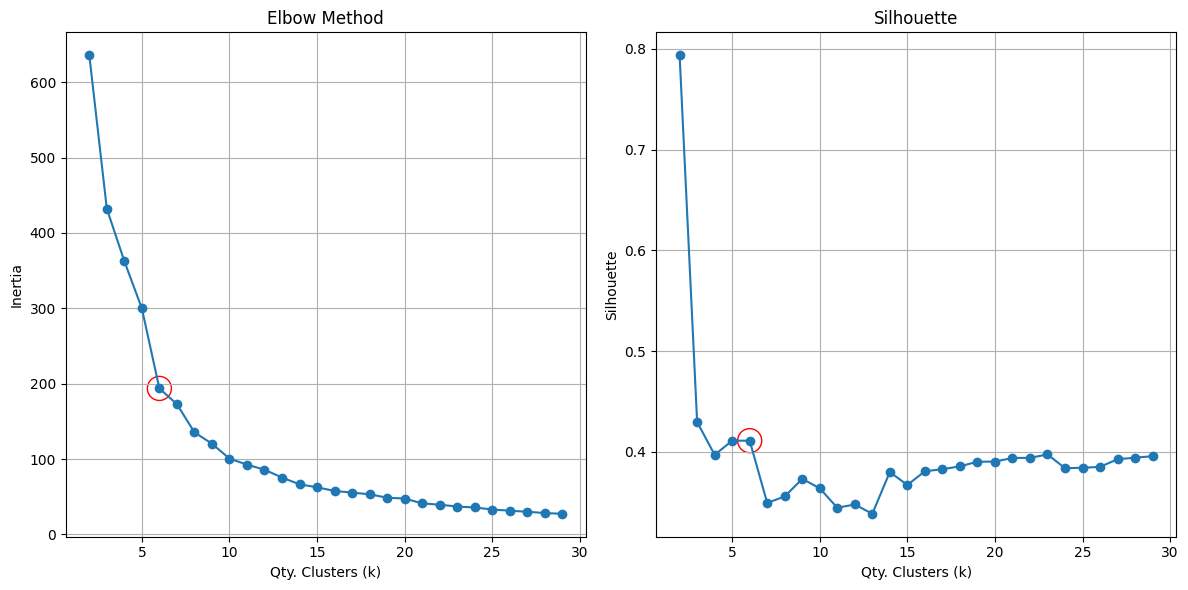

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(list(range(2, 30)), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Qty. Clusters (k)')
plt.ylabel('Inertia')
plt.grid()

x_highlight = 6
y_highlight = 193.66
plt.scatter(x_highlight, y_highlight, s=300, facecolors='none', edgecolors='r')

plt.subplot(1, 2, 2)
plt.plot(list(range(2, 30)), silhouette_scores, marker='o')
plt.title('Silhouette')
plt.xlabel('Qty. Clusters (k)')
plt.ylabel('Silhouette')
plt.grid()

x_highlight = 6
y_highlight = 0.4111
plt.scatter(x_highlight, y_highlight, s=300, facecolors='none', edgecolors='r')

plt.tight_layout()
plt.show()

In [7]:
# I will choose k = 6 mainly because of the silhouette coefficient

### Creating Clusters

In [4]:
kmeans = KMeans(n_clusters=100, random_state=777, algorithm='lloyd').fit(loc_df)

In [5]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']].values)
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']].values)

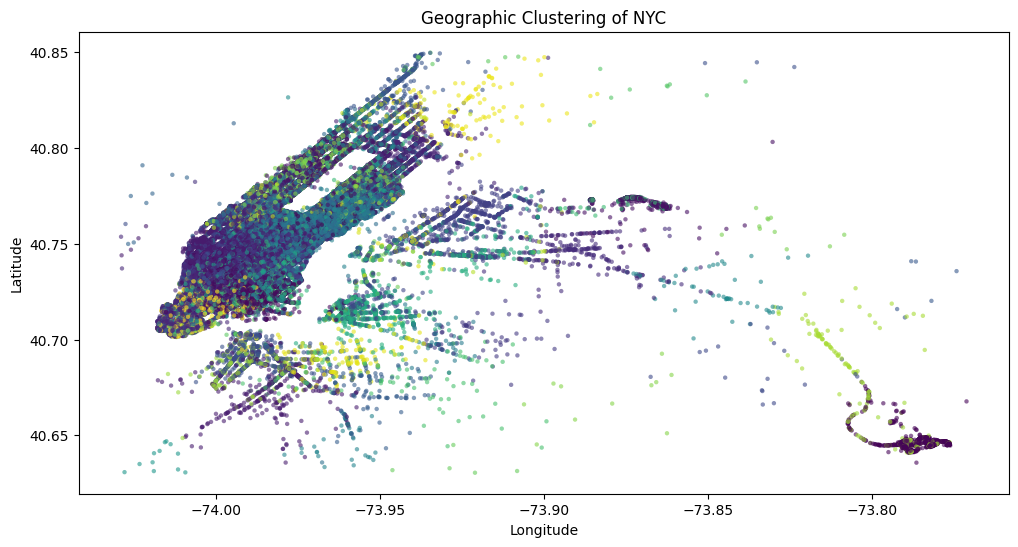

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
ax.scatter(df['pickup_longitude'].values, 
           df['pickup_latitude'].values, s=10, lw=0,
           c=df['pickup_cluster'].values, alpha=0.6)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.gca()#.set_aspect('equal', adjustable='box')
plt.title('Geographic Clustering of NYC')
plt.show()

# Feature Engineering

In [9]:
class FeatureEngineering():
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def create_features(self, X):
        X = X.reset_index(drop=True)
        X_tmp = X.reset_index(drop=True)

        X_tmp['day_of_week'] = X_tmp['pickup_datetime'].dt.weekday

        new_columns = [col for col in X_tmp.columns if col not in X.columns]
        X_tmp = X.merge(X_tmp[new_columns], left_index=True, right_index=True , how='left')
        
        return X_tmp

    def transform(self, X):
        return self.create_features(X)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)



In [10]:
fe = FeatureEngineering()

In [11]:
fe.transform(df).head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year_month_day,daily_preciptation_normal_inches,max_temperature_normal_f,min_temperature_normal_f,avg_temperature_normal_f,BIKE_LANE,BOROCODE,ST_WIDTH,TRAFDIR,RW_TYPE,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,BIKE_TRAFD,SEGMENT_TY,day_of_week
0,id1718206,1,2016-01-05 10:07:14,1,-73.990273,40.766647,-73.992729,40.748363,N,20160105,0.12,40,29,35,None,1,44,FT,2,C,None,None,None,AVE,None,None,None,R,1
1,id1748564,2,2016-01-07 14:38:51,1,-73.976311,40.759819,-73.957603,40.779598,N,20160107,0.12,40,29,34,1,1,60,FT,1,C,None,None,AVE,None,None,None,FT,U,3
2,id3792886,1,2016-05-29 22:11:39,2,-74.006760,40.749096,-73.972206,40.757252,N,20160529,0.14,75,59,67,None,1,54,FT,2,C,None,None,None,AVE,None,None,None,R,6
3,id2541269,2,2016-03-01 12:33:26,5,-73.982689,40.782124,-73.956490,40.781673,N,20160301,0.13,45,32,39,None,1,32,FT,2,C,None,None,None,PKWY,None,None,None,R,1
4,id3152266,2,2016-04-14 18:52:23,1,-73.802071,40.663708,-73.982391,40.766552,N,20160414,0.13,61,45,53,None,4,36,FT,2,C,None,None,None,EXPY,None,None,None,U,3
